# Section 1
In this section of tutorial, you will:
1. Load and profile a simulated dataset
2. Examine the distribution of classifier scores
3. Examine the distribution of ground truth labels
4. Construct three representations of the joint distribution
5. Use a naive approach, classify and count, to estimate ground truth prevalence without using the ground truth labels

For the exercises, we ask you to rerun this code on a different dataset and answer the following questions:
1. What is the most common classifier output (approximately)?
2. What is the fraction of positive GT labels (approximately)?
3. From the stacked_frequency_plot, when the classifier outputs 0.5, are ground truth labels more likely to be positive or negative?
4. Looking at the correct classifier calibration curve
  a. At what classifier output is GT 50/50 positive/negative?
  b. At what classifier outputs is the classifier most wrong?
5. Using the naive probabilistic classify and count procedure, what is the estimated prevalence of ground truth positive labels?
6. What classifier density plot would lead to a PCC estimate that was pretty accurate? 
7. What classifier density plot would lead to a PCC estimate that was very inaccurate?

You should also fill in column B for dataset 2 in your copy of the [results spreadsheet]( https://docs.google.com/spreadsheets/d/10oEQR-_6px9sRF3cRiIPChiBcrWPVPy12TN7oHCA4qU), based on your findings from the notebook.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

from util import plot_stacked_frequency
from util import DataHandler, PerfectCalibrationCurve, NPBinningCalibrationCurve, ProbabilityEstimator

## 1. Load and profile a simulated dataset

In [2]:
# base is a very large dataset
base_dh = DataHandler('data/dataset1_base.csv')

In [3]:
# TODO for exercises: use this dataset instead
# base_dh = DataHandler('data/dataset1_target.csv')

In [4]:
# you observe only classifier scores C(X), but no GT labels
base_dh.observed_df

,C(X),GT
0,0.254796,
1,0.888630,
2,0.815468,
3,0.801820,
4,0.209585,
...,...,...
99995,0.383462,
99996,0.937050,
99997,0.066808,
99998,0.358555,


In [5]:
# count_gt() function returns the number of items with GT labels
base_dh.count_gt()

0

## 2. The Distribution of Classifier Scores
There is a theoretcial random variable representing the classifier scores C(X) for items randomly drawn from a distribution of item states X.

We plot the empirical density of C(X). With a large enough dataset, this is a good approximation of random variable's density function.

In our case, we are working with a *soft classifier* that always outputs scores between 0 and 1. Thus, we we get a continuous density plot.

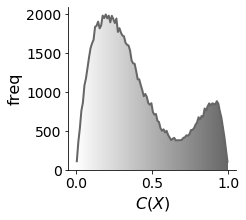

In [6]:
base_dh.plot_dist_classifier_scores(fig_name='base_dist_classifier_scores')

## 3. The Distribution of Ground Truth Labels
There is a theoretical random variable GT(X) representing the ground truth labels for items randomly drawn from the distribution of item states X. 

We plot the empirical density of GT(X). With a large enough dataset, this is a good approximation of random variable's density function.

In our case, Ground Truth is a binary label. (Note: for convenience, we will refer to the binary labels interchangeably as True/False, 1/0, and positive/negative). Thus, we we get a discrete density plot, a bar graph showing the frequency of each of the two ground truth labels. We normalize by the the total number of labels, so that the y-axis can be read off as P(GT).

In practice, we would not have access to Ground Truth labels for all items, since they are expensive to gather. That is the reason for wanting to use the classifier to do our prevalence estimation. But to aid in understanding how well we are predicting that prevalence, the ground truth labels for items are avaialble for our synthetic datasets through an oracle function.

In [7]:
# get GT labels for all items
base_dh.get_all_oracle()

In [8]:
base_dh.observed_df

,C(X),GT
0,0.254796,False
1,0.888630,True
2,0.815468,True
3,0.801820,True
4,0.209585,False
...,...,...
99995,0.383462,False
99996,0.937050,True
99997,0.066808,False
99998,0.358555,False


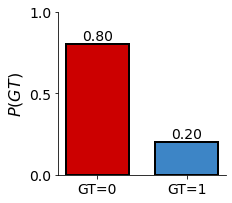

In [9]:
base_dh.plot_dist_gt_labels(fig_name='base_dist_gt_labels')

## 4. Representation of Joint Distribution

The classifier output can be used in prevalence estimation because we think classifier outputs are correlated with GT labels. The joint distribution between the two random variables C(X) and GT(X) tells us how they are related. Again, we will plot the empirical joint distribution as an approximation of the underlying theoretical joint distribution.

There are three different ways that we can represent a joint distribution in plots.

1) **stacked frequency plot**: a colorized version of the classifier density plot.
  - For each C(x) value, the proportion of the density that is colored blue represents pr(GT=1 | C(x))

2) **classifier calibration curve** plus **classifier density plot**
  - In the calibration curve, the y-axis shows pr(GT=1 | C(x))

3) **class conditional density plots** plus **GT distribution**: 
  - a red plot shows the density of C(X) when GT is negative
  - a blue plot shows the density of C(X) when GT is positive
  - a bar graph shows the probability of GT+ and the probability of GT-

  
Given any one of these (sets of) plots, it would be possible to generate the other two, even if we didn't have the underlying empirical dataset.

To get from representation 2 to representation 1, we merely use the calibration curve to colorize each vertical slice of the classifier density plot.

To get from representation 2 to representation 3:
- for the GT distribution, we just integrate the area under the red and blue curves in the JD plot.
- for the positive density function, we extract just the red shaded region from the JD plot and renormalize the y-axis so that the total area adds up to 1. And similarly for the negative density function, using the red shaded area.

Note also that the GT plot that is part of representation 3 is exactly the thing that we are hoping to estimate: the ground truth prevalence. Thus, if we are able to get an estimate of the joint distribution in terms of the classifier density plot C(X) and the classifier calibration curve, we will have enough information to generate an estimate of GT.

#### 1) Single Stacked Frequency Plot

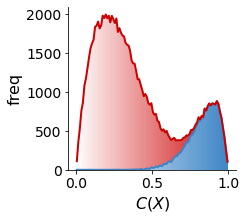

In [10]:
base_dh.plot_stacked_frequency(fig_name='base_stacked_frequency')

#### 2) **classifier calibration curve** + **classifier density plot**

In [11]:
base_calibration_curve = NPBinningCalibrationCurve(base_dh.observed_df, num_bin=100)

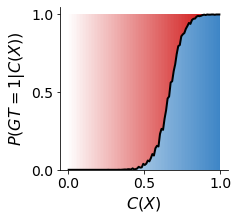

In [12]:
base_calibration_curve.plot(fig_name='base_calibration_curve')

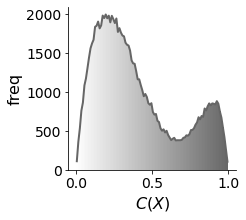

In [13]:
base_dh.plot_dist_classifier_scores(fig_name='base_dist_classifier_scores')

#### 3) **class conditional density plots** + **GT distribution**

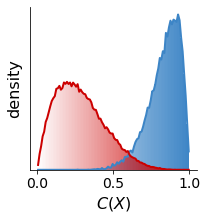

In [14]:
base_dh.plot_class_conditional_density(fig_name='base_class_conditional_density')

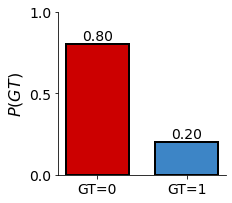

In [15]:
base_dh.plot_dist_gt_labels(fig_name='base_dist_gt_labels')

### A convenient view of all five distribution representations

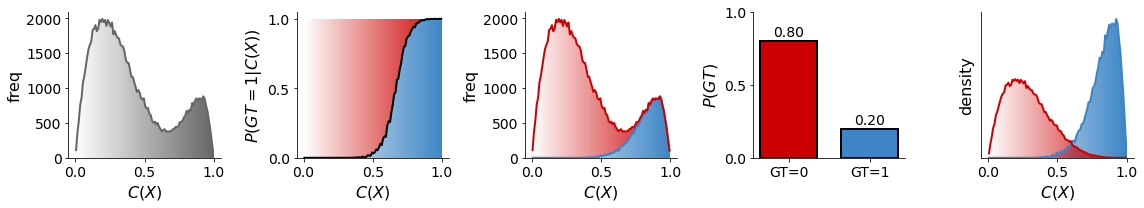

In [16]:
base_dh.generate_all_distribution_plots(df=base_dh.observed_df)

## 5. Naive Estimation Approach: Treat Classifier as Calibrated
One naive approach to prevalence estimation is called **probabilistic classify and count (PCC)**. To get an estimate of the number of GT positive labels in a dataset, just add up the clasifier outputs for all the items.

In the framework we are building up, that corresponds to assuming that the classifier is **calibrated**. A classifier is said to be calibrated if, for any classifier output C(x), of all items where it outputs that score, the fraction of items that have positive GT labels is exactly C(x). For example, when a classifier outputs 0.7, 70% of the time the item has a positive GT label.

If a classifier is calibrated, the calibration curve will be just a diagonal line with slope 1. We illustrate this below with the **perfect calibration curve**.

With classifier density plot and the assumed perfect calibration curve, we have representation 2 of the joint distribution. From that, we can integrate to get the relative size of the red and blue shaded areas in the joint distribution, and thus get GT. Indeed, summing up the classifier outputs for each of the items, as is done in the PCC approach, is just integrating to get the area of the red and blue shaded regions.

In [17]:
base_dh.observed_df

,C(X),GT
0,0.254796,False
1,0.888630,True
2,0.815468,True
3,0.801820,True
4,0.209585,False
...,...,...
99995,0.383462,False
99996,0.937050,True
99997,0.066808,False
99998,0.358555,False


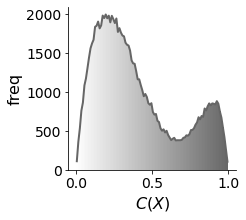

In [18]:
base_dh.plot_dist_classifier_scores()

#### Treat the classifier scores as calibrated scores

The pcc is equivalent to assuming an perfect_calibration_curve and using that to generate an estimated version of representation 3, which includes a GT distribution.

In [19]:
perfect_calibration_curve = PerfectCalibrationCurve()

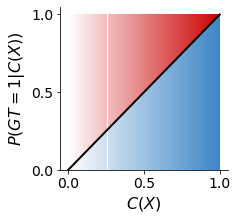

In [20]:
perfect_calibration_curve.plot()

In [21]:
input_cx_array = base_dh.observed_df['C(X)'].values

In [22]:
pcc_estimator = ProbabilityEstimator()
pcc_estimator.set_calibration_curve(perfect_calibration_curve)

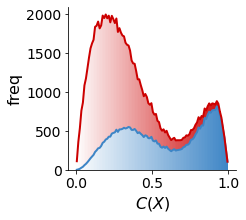

In [23]:
pcc_estimator.plot(input_cx_array)

In [24]:
# our estimated prevalence
pcc_estimator.estimate(input_cx_array)

0.39471062263377144

##### Note the Wrong Estimate if Classifier is not Actually Calibrated
For this dataset, with access to the oracle telling us all the GT labels, we can see that the classifier's actual calibration curve was not the idealized one that PCC assumes.

And we can see that it produces an estimate prevalence of positive GT that is far from the true prevalence.

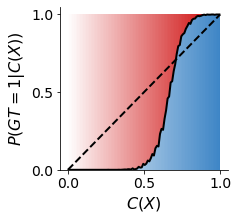

In [25]:
base_calibration_curve.plot(show_diagonal=True)

In [26]:
# correct prevalence estimation using the true calibration curve
correct_pe_estimator = ProbabilityEstimator()
correct_pe_estimator.set_calibration_curve(base_calibration_curve)

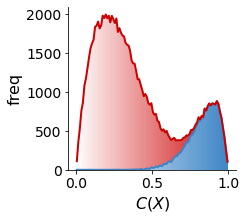

In [27]:
correct_pe_estimator.plot(input_cx_array)

In [28]:
correct_pe_estimator.estimate(input_cx_array)

0.19999999999999996

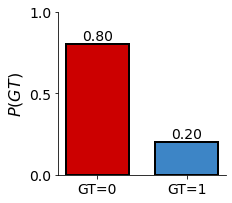

In [29]:
## the true prevalence
base_dh.plot_dist_gt_labels()